## Import packages and load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from geneinfo.coords import gene_coords
import geneinfo.plot as gplt



In [2]:
LinARs_df = pd.read_csv("../data/adc9507_Data_S1.csv", sep=";", skiprows=2)
LinARs_df = LinARs_df.dropna(axis=1, how="all")
LinARs_df.head()

,Chr,Start,End,LinAR_ID,Nearest_Neighboring_Gene,lncRNA_ID,cCREs_ID,Gene_name,Lineage_name,PhyloP score,P-value,Q-value
0,chr3,82154474,82154736,HLinAR-Rank1,NONE,URS0000EBC6E1_9606,NONE,NONE,Human,"167,07914",0,0
1,chr21,8424934,8425419,HLinAR-Rank2,NONE,URS00019A85AC_9606,NONE,NONE,Human,"97,33254",0,0
2,chr20,63102113,63102273,HLinAR-Rank3*,ENSG00000149658,URS0000EF61E2_9606,EH38E2128905,YTHDF1,Human,"90,33879",0,0
3,chr21,8424387,8424860,HLinAR-Rank4,NONE,URS00019A85AC_9606,NONE,NONE,Human,"88,65024",0,0
4,chr21,8241960,8242395,HLinAR-Rank5,NONE,URS0001A07CFE_9606,NONE,NONE,Human,"81,2051",0,0


## Distribution of LinARs 

### Total number of LinARs

In [3]:
# Data frame size (number of rows = number of LinARs)
LinARs_df.shape

(86409, 12)

In [4]:
# Total number of lineages
LinARs_df["Lineage_name"].nunique()


67

In [5]:
# Check for LinARs duplicates in lineages
LinARs_duplicates = LinARs_df[LinARs_df.duplicated(subset=["Lineage_name", "Chr", "Start", "End"], keep=False)]
LinARs_duplicates.groupby("Lineage_name").size()


Series([], dtype: int64)

In [6]:
# Number of unique LinARs
LinARs_unique = LinARs_df.drop_duplicates(subset=["Chr", "Start", "End"])
len(LinARs_unique)


71332

In [7]:
# Number of LinAR regions shared between species
len(LinARs_df) - len(LinARs_unique) # There were no duplicates within a lineage, therefore the remaining LinARs are shared between species

15077

### Number of LinARs across lineage

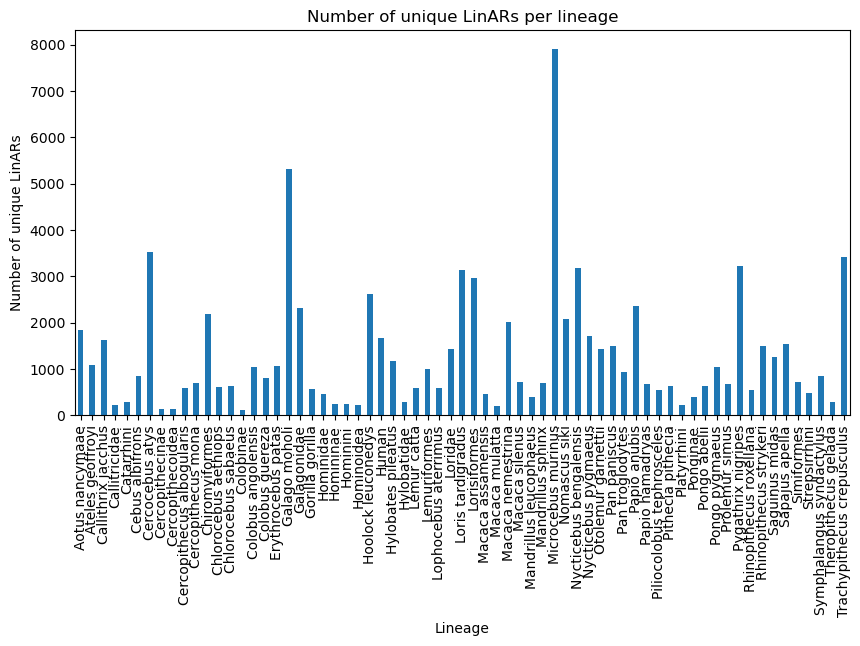

count      67.000000
mean     1289.686567
std      1323.122778
min       110.000000
25%       513.500000
50%       811.000000
75%      1654.000000
max      7915.000000
dtype: float64


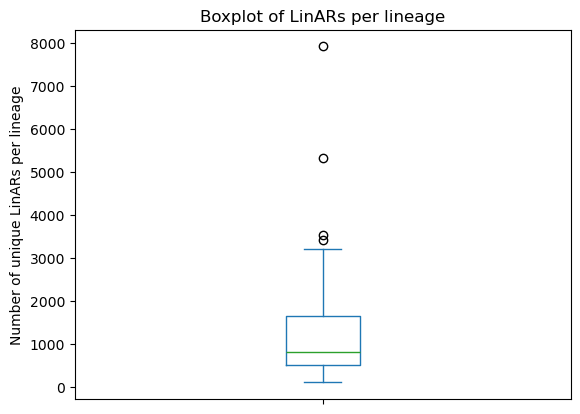

In [8]:
# Number of LinARs per lineage 
LinARs_per_lineage = LinARs_df.groupby("Lineage_name")[["Chr", "Start", "End"]].size()

LinARs_per_lineage.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of unique LinARs")
plt.xlabel("Lineage")
plt.title("Number of unique LinARs per lineage")
plt.show()

# Summary statistics for number of LinARs per lineage
print(LinARs_per_lineage.describe())

LinARs_per_lineage.plot(kind="box")
plt.ylabel("Number of unique LinARs per lineage")
plt.title("Boxplot of LinARs per lineage")
plt.show()

In [9]:
# Number of LinARs in human and chimpanzee

print("Number of LinARs in human:", LinARs_per_lineage["Human"])
print("Number of LinARs in chimpanzee:", LinARs_per_lineage["Pan troglodytes"])

Number of LinARs in human: 1674
Number of LinARs in chimpanzee: 933


In [10]:
# Number of conserved elements identified as LinARs in all lineages (regions that exist in all lineages)

n_lineages = LinARs_df["Lineage_name"].nunique()

LinARs_all_lineages = (
    LinARs_df.groupby(["Chr", "Start", "End"])["Lineage_name"]
    .nunique()
    .eq(n_lineages) # Check if the number of unique lineages for each LinAR equals the total number of lineages
)

LinARs_all_lineages.sum()

np.int64(0)

In [11]:
# Number of conserved elements identified as LinARs in both human and chimpanzee
human = "Human"    
chimp = "Pan troglodytes"  

# Get sets of coordinate tuples for each species
LinARs_human = set(tuple(x) for x in LinARs_df[LinARs_df["Lineage_name"] == human][["Chr", "Start", "End"]].values)
LinARs_chimp = set(tuple(x) for x in LinARs_df[LinARs_df["Lineage_name"] == chimp][["Chr", "Start", "End"]].values)

# Find shared LinARs by coordinates
shared_linars = LinARs_human & LinARs_chimp
len(shared_linars)


119

/var/folders/pz/y0tgvym13cg8yjfc14z454cr0000gn/T/ipykernel_34417/1989180919.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_linars_per_species = unique_linars.groupby("Lineage_name").apply(


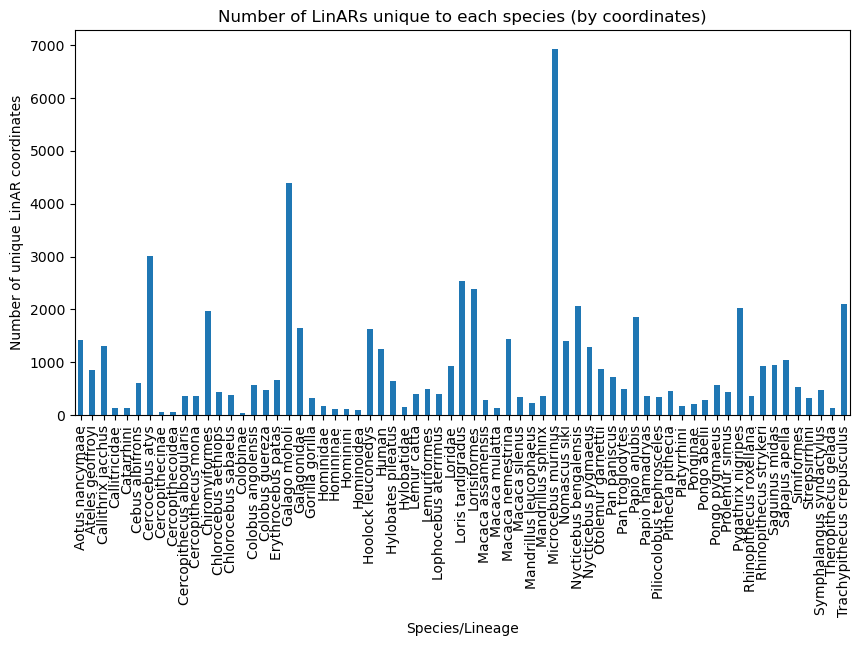

In [38]:

# Count how many unique LinAR coordinates are found only in one lineage/species

# Group by coordinates and count unique lineages for each region
coord_lineage_counts = LinARs_df.groupby(["Chr", "Start", "End"])["Lineage_name"].nunique()

# Find coordinates that only exist in one lineage
unique_coords = coord_lineage_counts[coord_lineage_counts == 1].index

# Filter original dataframe to only those unique coordinates
unique_linars = LinARs_df.set_index(["Chr", "Start", "End"]).loc[unique_coords].reset_index()

# Count unique coordinate tuples per lineage/species
unique_linars_per_species = unique_linars.groupby("Lineage_name").apply(
    lambda x: x.drop_duplicates(subset=["Chr", "Start", "End"]).shape[0]
)

unique_linars_per_species.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of unique LinAR coordinates")
plt.xlabel("Species/Lineage")
plt.title("Number of LinARs unique to each species (by coordinates)")
plt.show()



### Number of HARs

In [12]:
# Number of HARs (new and previous identified), meaning number of human LinARs

print(LinARs_per_lineage["Human"])


1674


In [13]:
# Total number of unique previous identified HARs (LinArs with "*")
LinARs_df.loc[LinARs_df["LinAR_ID"].str.contains("\*"), "LinAR_ID"].nunique()

<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
/var/folders/pz/y0tgvym13cg8yjfc14z454cr0000gn/T/ipykernel_34417/1447174711.py:2: SyntaxWarning: invalid escape sequence '\*'
  LinARs_df.loc[LinARs_df["LinAR_ID"].str.contains("\*"), "LinAR_ID"].nunique()


620

<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
/var/folders/pz/y0tgvym13cg8yjfc14z454cr0000gn/T/ipykernel_34417/2913380675.py:3: SyntaxWarning: invalid escape sequence '\*'
  HARs_per_lineage = LinARs_df[LinARs_df["LinAR_ID"].str.contains("\*")].groupby("Lineage_name")[["Chr", "Start", "End"]].size()


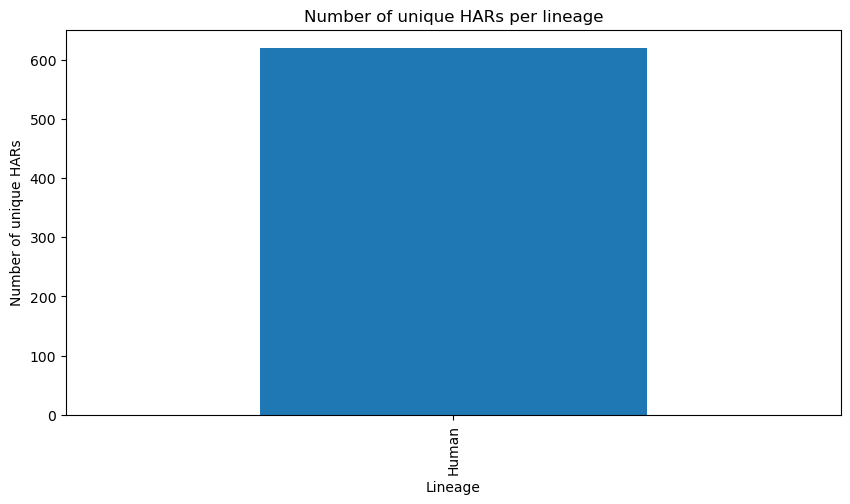

In [14]:
# Number of HARs per lineage (shows that only the human lineage has HARs)

HARs_per_lineage = LinARs_df[LinARs_df["LinAR_ID"].str.contains("\*")].groupby("Lineage_name")[["Chr", "Start", "End"]].size()

HARs_per_lineage.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of unique HARs")
plt.xlabel("Lineage")
plt.title("Number of unique HARs per lineage")
plt.show()


### Number of LinARs across chromosomes

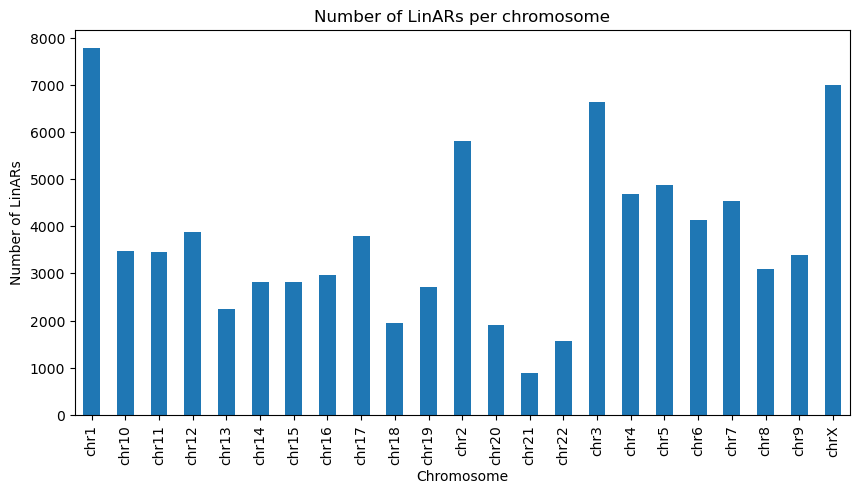

count      23.000000
mean     3756.913043
std      1762.875412
min       885.000000
25%      2760.500000
50%      3449.000000
75%      4612.000000
max      7780.000000
dtype: float64


In [16]:
# Number of LinARs per chromosome (include multiple count of regions that exist in multiple lineages)

LinARs_per_chromosome = LinARs_df.groupby("Chr").size()       

LinARs_per_chromosome.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of LinARs")
plt.xlabel("Chromosome")
plt.title("Number of LinARs per chromosome")
plt.show()

print(LinARs_per_chromosome.describe())

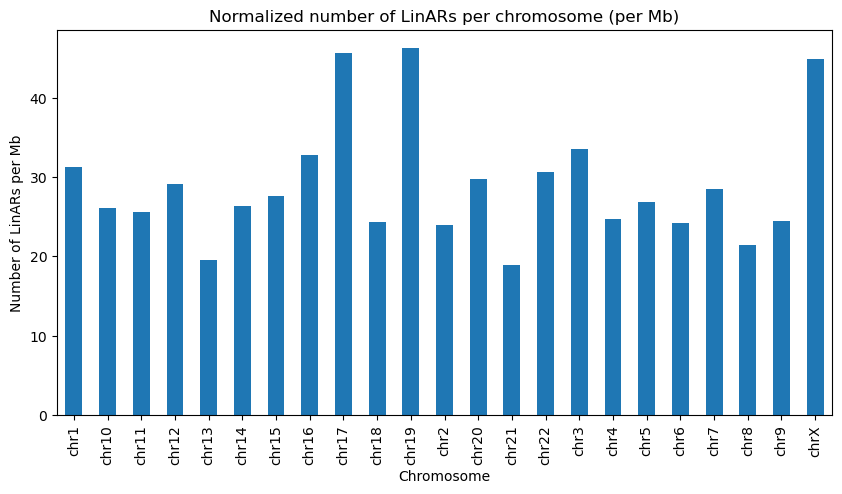

count    23.000000
mean     28.957003
std       7.574360
min      18.946699
25%      24.397735
50%      26.864860
75%      30.964136
max      46.231836
dtype: float64


In [17]:
# Number of LinARs per chromosome normalized by chromosome length

chrom_lengths = {
    "chr1": 248956422,
    "chr2": 242193529,
    "chr3": 198295559,
    "chr4": 190214555,
    "chr5": 181538259,
    "chr6": 170805979,
    "chr7": 159345973,
    "chr8": 145138636,
    "chr9": 138394717,
    "chr10": 133797422,
    "chr11": 135086622,
    "chr12": 133275309,
    "chr13": 114364328,
    "chr14": 107043718,
    "chr15": 101991189,
    "chr16": 90338345,
    "chr17": 83257441,
    "chr18": 80373285,
    "chr19": 58617616,
    "chr20": 64444167,
    "chr21": 46709983,
    "chr22": 50818468,
    "chrX": 156040895,
}

LinARs_per_chromosome_norm = LinARs_per_chromosome / pd.Series(chrom_lengths) * 1e6

LinARs_per_chromosome_norm.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of LinARs per Mb")
plt.xlabel("Chromosome")
plt.title("Normalized number of LinARs per chromosome (per Mb)")
plt.show()


print(LinARs_per_chromosome_norm.describe())


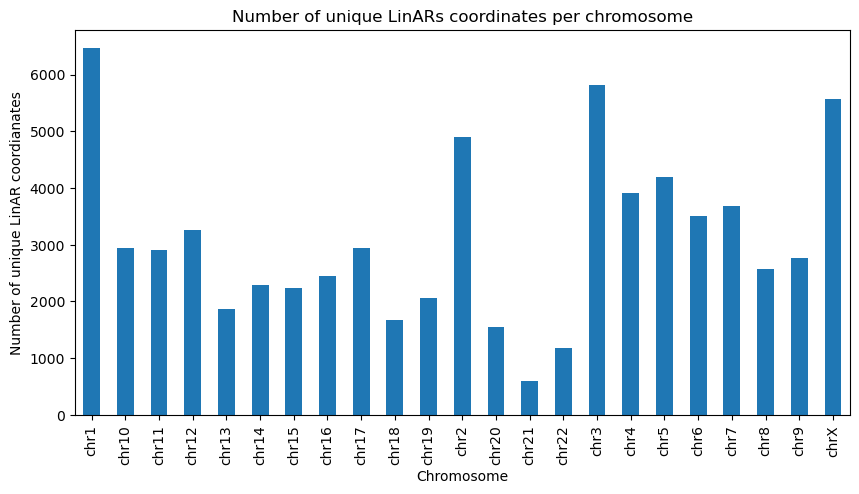

count      23.000000
mean     3101.391304
std      1501.865892
min       591.000000
25%      2144.000000
50%      2911.000000
75%      3793.500000
max      6464.000000
dtype: float64


In [18]:
# Number of unique accelerated regions per chromosome / Number of unique LinAR coordinates per chromosome (only count each region once, even if it appears in multiple lineages). 


LinARs_per_chromosome_unique = LinARs_df.drop_duplicates(subset=["Chr", "Start", "End"]).groupby("Chr").size()

LinARs_per_chromosome_unique.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of unique LinAR coordianates")
plt.xlabel("Chromosome")
plt.title("Number of unique LinARs coordinates per chromosome")
plt.show()

print(LinARs_per_chromosome_unique.describe())

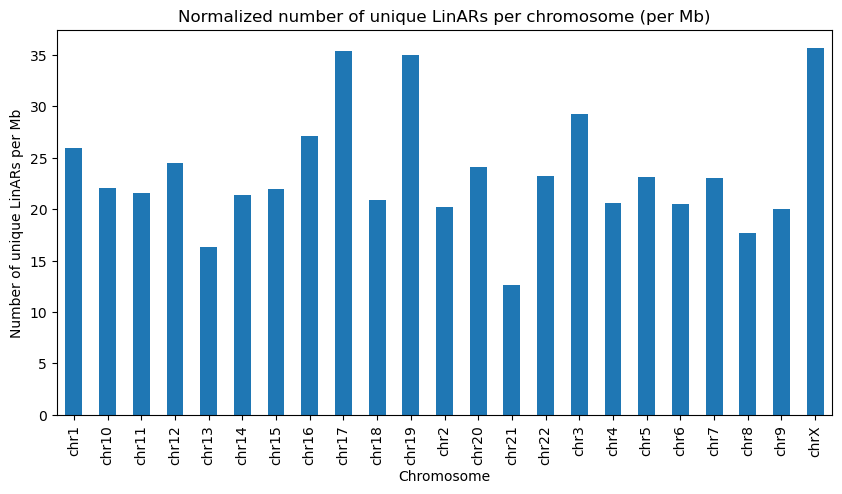

count    23.000000
mean     23.576868
std       5.794237
min      12.652542
25%      20.534224
50%      22.048257
75%      25.227521
max      35.644502
dtype: float64


In [19]:
# Number of unique accelerated regions per chromosome normalized by chromosome length

LinARs_per_chromosome_unique_norm = LinARs_per_chromosome_unique / pd.Series(chrom_lengths) * 1e6

LinARs_per_chromosome_unique_norm.plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of unique LinARs per Mb")
plt.xlabel("Chromosome")
plt.title("Normalized number of unique LinARs per chromosome (per Mb)")    
plt.show()

print(LinARs_per_chromosome_unique_norm.describe())

### LinARs lengths

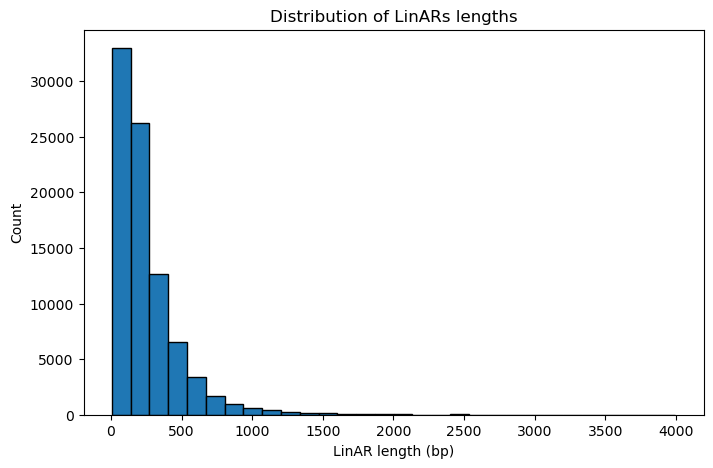

count    86409.000000
mean       252.294263
std        240.355371
min          6.000000
25%        101.000000
50%        181.000000
75%        319.000000
max       3997.000000
Name: Length, dtype: float64


In [20]:
# Distribution of LinAR lengths

LinARs_df["Length"] = LinARs_df["End"] - LinARs_df["Start"]

plt.figure(figsize=(8,5))
LinARs_df["Length"].plot(kind="hist", bins=30, edgecolor="black")
plt.xlabel("LinAR length (bp)")
plt.ylabel("Count")
plt.title("Distribution of LinARs lengths")
plt.show()

print(LinARs_df["Length"].describe())


### LinAR intervals and density

In [67]:
# All LinARs (across all lineages)
all_intervals = list(LinARs_df[['Chr', 'Start', 'End']].itertuples(index=False, name=None))

# Only Human LinARs
human_intervals = list(
    LinARs_df.loc[LinARs_df["Lineage_name"] == "Human", ['Chr', 'Start', 'End']]
    .itertuples(index=False, name=None)
)

# Only Pan troglodytes LinARs
pan_intervals = list(
    LinARs_df.loc[LinARs_df["Lineage_name"] == "Pan troglodytes", ['Chr', 'Start', 'End']]
    .itertuples(index=False, name=None)
)

annot = pd.DataFrame.from_records(all_intervals, columns=['chrom', 'start', 'end'])
print(annot)


       chrom      start        end
0       chr3   82154474   82154736
1      chr21    8424934    8425419
2      chr20   63102113   63102273
3      chr21    8424387    8424860
4      chr21    8241960    8242395
...      ...        ...        ...
86404  chr10   24790517   24790607
86405   chr6   31897234   31897548
86406  chr10   38080656   38080737
86407   chr9  111661655  111661715
86408   chr2  114525954  114526226

[86409 rows x 3 columns]


In [69]:
from genominterv.remapping import remap

annot_collapsed = interval_collapse(annot)
annot_collapsed

ModuleNotFoundError: No module named 'genominterv'

## Distribution of closest genes

## Distribution of genes from yaml file

### Load gene lists and get gene coordinates

In [57]:
import geneinfo.information as gi
import yaml

# Load gene data from YAML file

with open("../data/cecilie_gen_lister.yaml", "r") as f:
    gene_data = yaml.safe_load(f)

print(gene_data.keys())



dict_keys(['cDEG_human', 'nDEG_human', 'nDEG_chimp', 'nDEG_bonobo', 'neuron_genes', 'human_spermatid_expressed_genes'])


In [ ]:
# Extract gene lists

cDEG_human_genes = gene_data['cDEG_human']['genes']
neuron_genes = gene_data['neuron_genes']['genes']
human_spermatid_genes = gene_data['human_spermatid_expressed_genes']['genes']

cDEG_human_genes_list = [gene.strip() for gene in cDEG_human_genes.split(",")]
cDEG_human_genes_list = set(cDEG_human_genes_list)

neuron_genes_list = [gene.strip() for gene in neuron_genes.split(",")]
neuron_genes_list = set(neuron_genes_list)

human_spermatid_genes_list = [gene.strip() for gene in human_spermatid_genes.split(",")]
human_spermatid_genes_list = set(human_spermatid_genes_list)

'AKAP4, BRWD3, CFAP47, DDX3X, DIAPH2, DYNLT3, EDA, FHL1, FTSJ1, HDX, HTR2C, OFD1, PDK3, SYP, SYTL5, UPF3B, BEX2, FUNDC1, SPANXN5, DDX3Y'

In [ ]:
# Count number of genes in each list
print("Total number of cDEG genes:", len(cDEG_human_genes_list))
print("Total number of neuron genes:", len(neuron_genes_list))
print("Total number of spermatid genes:", len(human_spermatid_genes_list))


Total number of cDEG genes: 20
Total number of neuron genes: 562
Total number of spermatid genes: 684


{'AKAP4',
 'BEX2',
 'BRWD3',
 'CFAP47',
 'DDX3X',
 'DDX3Y',
 'DIAPH2',
 'DYNLT3',
 'EDA',
 'FHL1',
 'FTSJ1',
 'FUNDC1',
 'HDX',
 'HTR2C',
 'OFD1',
 'PDK3',
 'SPANXN5',
 'SYP',
 'SYTL5',
 'UPF3B'}

In [ ]:
# Get coordinates

cDEG_coords = gene_coords(cDEG_human_genes_list, assembly='hg38')
cDEG_coords
neuron_coords = gene_coords(neuron_genes_list, assembly='hg38')
neuron_coords
human_spermatid_coords = gene_coords(human_spermatid_genes_list, assembly='hg38')
human_spermatid_coords

[('chrX', 80669502, 80809877, 'BRWD3'),
 ('chrX', 53422872, 53431115, 'RIBC1'),
 ('chrX', 103062650, 103064171, 'BEX1'),
 ('chrX', 107052101, 107118822, 'RBM41'),
 ('chrX', 151716034, 151723194, 'FATE1'),
 ('chrX', 141173234, 141177129, 'LDOC1'),
 ('chrX', 53048788, 53080615, 'GPR173'),
 ('chrX', 71533103, 71575892, 'OGT'),
 ('chrX', 154778683, 154805485, 'MPP1'),
 ('chrX', 103376322, 103378164, 'BEX3'),
 ('chrX', 43766609, 43882450, 'MAOB'),
 ('chrX', 15345590, 15491309, 'PIR-FIGF'),
 ('chrX', 41085444, 41236579, 'USP9X'),
 ('chrX', 84058345, 84188499, 'RPS6KA6'),
 ('chrX', 150766335, 150898668, 'CD99L2'),
 ('chrX', 77504879, 77786216, 'ATRX'),
 ('chrX', 13035616, 13044620, 'FAM9C'),
 ('chrX', 101391010, 101396155, 'RPL36A'),
 ('chrX', 38269162, 38327509, 'RPGR'),
 ('chrX', 115561173, 115650861, 'PLS3'),
 ('chrX', 141838315, 141897832, 'MAGEC3'),
 ('chrX', 46599250, 46759118, 'SLC9A7'),
 ('chrX', 123859707, 123913972, 'XIAP'),
 ('chrX', 43655005, 43746817, 'MAOA'),
 ('chrX', 119895892

### Number of neuron and spermatid genes in LinARs df

In [134]:
# Filter and count how many rows in LinARs df whose Gene_name is not "NONE"
filtered_LinARs_df = LinARs_df[LinARs_df["Gene_name"]!= "NONE"] 
print(filtered_LinARs_df.shape[0])

# Percentage of LinARs with assigned Gene_name
print(filtered_LinARs_df.shape[0] / LinARs_df.shape[0] * 100)

64397
74.52580171046998


In [135]:
# How many of the cDEG_human_genes are found in the LinARs df (based on Gene_name)
# Find intersection between LinARs Gene_name and cDEG_human_genes
cDEG_in_LinARs = filtered_LinARs_df[filtered_LinARs_df["Gene_name"].isin(cDEG_human_genes_list)]
print("Number of times a cDEG gene was found in the df:",cDEG_in_LinARs.shape[0])
print("Number of unique cDEG genes in df", cDEG_in_LinARs["Gene_name"].nunique())

# How many of the neuron_genes are found in the LinARs df (based on Gene_name)
neuron_in_LinARs = filtered_LinARs_df[filtered_LinARs_df["Gene_name"].isin(neuron_genes_list)]
print("Number of times a neuron gene was found in the df:", neuron_in_LinARs.shape[0])
print("Number of unique neuron genes in df", neuron_in_LinARs["Gene_name"].nunique())

# How many of the human_spermatid_genes are found in the LinARs df (based on Gene_name)
human_spermatid_in_LinARs = filtered_LinARs_df[filtered_LinARs_df["Gene_name"].isin(human_spermatid_genes_list)]
print("Number of times a spermatid gene was found in the df:", human_spermatid_in_LinARs.shape[0])
print("Number of unique spermatid genes in df", human_spermatid_in_LinARs["Gene_name"].nunique())



Number of times a cDEG gene was found in the df: 186
Number of unique cDEG genes in df 16
Number of times a neuron gene was found in the df: 4448
Number of unique neuron genes in df 444
Number of times a spermatid gene was found in the df: 4259
Number of unique spermatid genes in df 408


In [136]:
# Proportion of genes in each list found in LinARs df

print("Proportion of cDEG genes found in LinARs df:", cDEG_in_LinARs["Gene_name"].nunique() / len(cDEG_human_genes_list) * 100)
print("Proportion of neuron genes found in LinARs df:", neuron_in_LinARs["Gene_name"].nunique() / len(neuron_genes_list) * 100)
print("Proportion of spermatid genes found in LinARs df:", human_spermatid_in_LinARs["Gene_name"].nunique() / len(human_spermatid_genes_list) * 100) 


Proportion of cDEG genes found in LinARs df: 80.0
Proportion of neuron genes found in LinARs df: 79.00355871886121
Proportion of spermatid genes found in LinARs df: 59.64912280701754


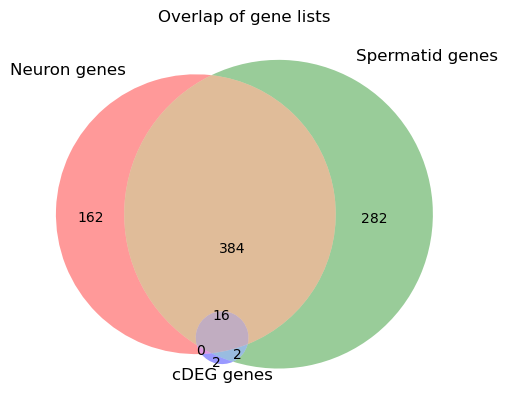

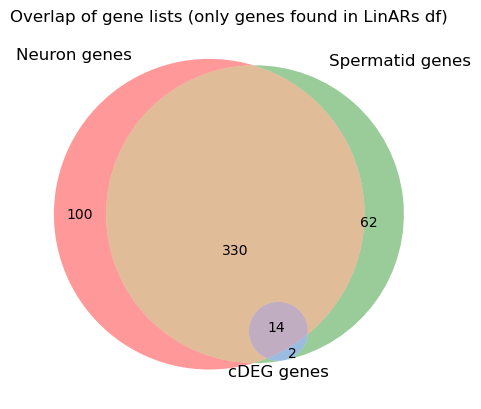

In [161]:
# Do some genes in the cDEG, neuron and spermatid list overlap?

# look at all genes in the lists
venn3(
    [neuron_genes_list, human_spermatid_genes_list, cDEG_human_genes_list],
    set_labels=("Neuron genes", "Spermatid genes", "cDEG genes")
)
plt.title("Overlap of gene lists")
plt.show()

# only include genes found in LinARs df
venn3([set(neuron_in_LinARs["Gene_name"]), set(human_spermatid_in_LinARs["Gene_name"]), set(cDEG_in_LinARs["Gene_name"])],
      set_labels=("Neuron genes", "Spermatid genes", "cDEG genes"))
plt.title("Overlap of gene lists (only genes found in LinARs df)")
plt.show()

### Gene positions on chromosomes

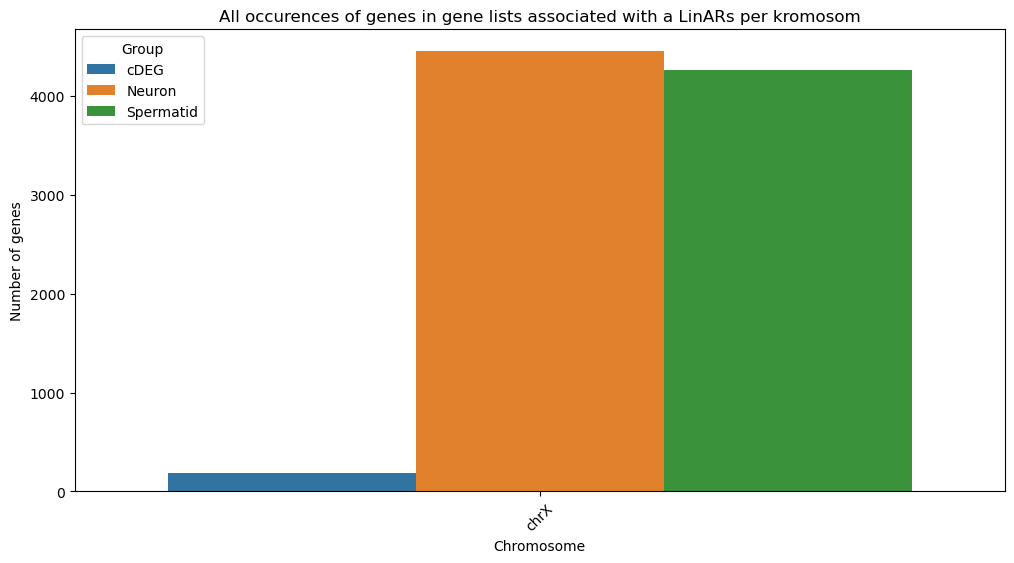

In [ ]:

# Create dataframe 
cDEG_df = cDEG_in_LinARs["Chr"].value_counts().reset_index()
cDEG_df.columns = ["Chr", "Count"]
cDEG_df["Group"] = "cDEG"

neuron_df = neuron_in_LinARs["Chr"].value_counts().reset_index()
neuron_df.columns = ["Chr", "Count"]
neuron_df["Group"] = "Neuron"

spermatid_df = human_spermatid_in_LinARs["Chr"].value_counts().reset_index()
spermatid_df.columns = ["Chr", "Count"]
spermatid_df["Group"] = "Spermatid"

chr_counts_df = pd.concat([cDEG_df, neuron_df, spermatid_df])


# Plot (all occurences of genes in gene lists associated with a LinARs per kromosom, meaning that if a gene appears multiple times in the LinARs df, it will be counted multiple times)
plt.figure(figsize=(12,6))
sns.barplot(data=chr_counts_df, x="Chr", y="Count", hue="Group")
plt.title("All occurences of genes in gene lists associated with a LinARs per chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of genes")
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.show()



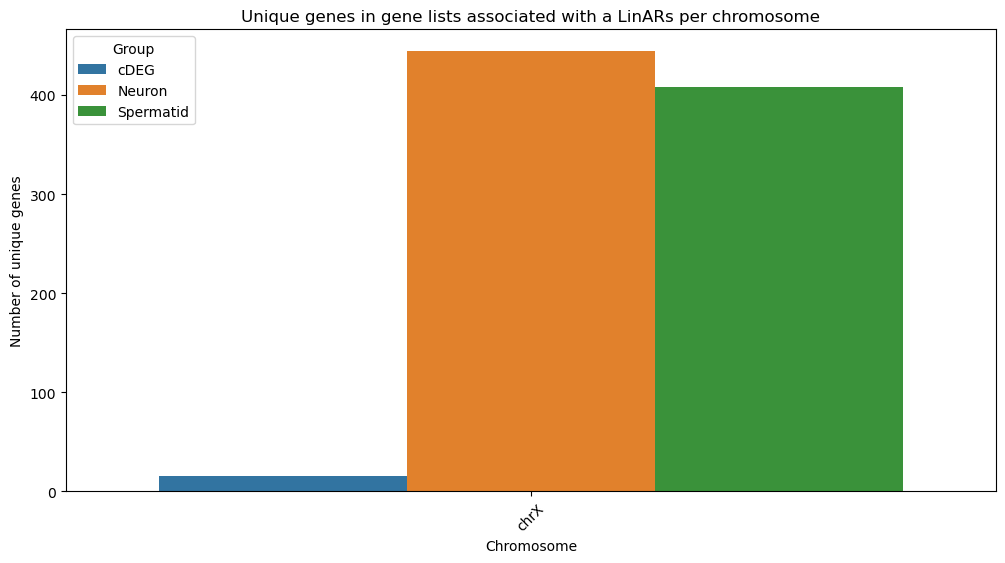

In [163]:
# Same plot as above but only count unique genes per chromosome (if a gene appears multiple times in the LinARs df, it will only be counted once)

cDEG_in_LinARs_unique = cDEG_in_LinARs.drop_duplicates(subset=["Gene_name"])
neuron_in_LinARs_unique = neuron_in_LinARs.drop_duplicates(subset=["Gene_name"])
human_spermatid_in_LinARs_unique = human_spermatid_in_LinARs.drop_duplicates(subset=["Gene_name"])

# Create dataframe 
cDEG_df = cDEG_in_LinARs_unique["Chr"].value_counts().reset_index()
cDEG_df.columns = ["Chr", "Count"]
cDEG_df["Group"] = "cDEG"

neuron_df = neuron_in_LinARs_unique["Chr"].value_counts().reset_index()
neuron_df.columns = ["Chr", "Count"]
neuron_df["Group"] = "Neuron"

spermatid_df = human_spermatid_in_LinARs_unique["Chr"].value_counts().reset_index()
spermatid_df.columns = ["Chr", "Count"]
spermatid_df["Group"] = "Spermatid"

chr_counts_df = pd.concat([cDEG_df, neuron_df, spermatid_df])

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=chr_counts_df, x="Chr", y="Count", hue="Group")
plt.title("Unique genes in gene lists associated with a LinARs per chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of unique genes")
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.show()


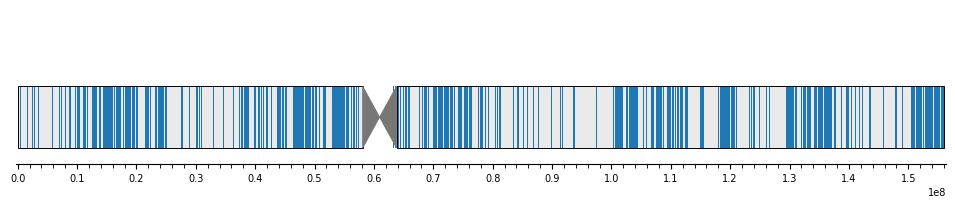

In [ ]:
#  Zoom in on chromosome X position

# combine cDEG_in_LinARs_unique, neuron_in_LinARs_unique, human_spermatid_in_LinARs_unique and keep only unique genes
combined_unique = pd.concat([cDEG_in_LinARs_unique, neuron_in_LinARs_unique, human_spermatid_in_LinARs_unique]).drop_duplicates(subset=["Gene_name"])

# Get a list of segments in combined_unique (chr, start, end)
segments = list(combined_unique[["Chr", "Start", "End"]].itertuples(index=False, name=None))

g = gplt.ChromIdeogram('chrX', assembly='hg38')
g.draw_chromosomes(base=1, height=4)
g.add_segments(segments, facecolor='tab:blue', alpha=0.2)

In [151]:
print(len(cDEG_in_LinARs_unique))
print(len(neuron_in_LinARs_unique))
print(len(human_spermatid_in_LinARs_unique))
print(len(combined_unique))

16
444
408
508


### Number of genes found in Chimpanzee and Human


In [ ]:
# Number of genes found in Chimpanzee and Human

# cDEG genes

cDEG_human_df = cDEG_in_LinARs[
    cDEG_in_LinARs["Lineage_name"] == human
][["Gene_name"]].drop_duplicates() 

cDEG_chimp_df = cDEG_in_LinARs[
    cDEG_in_LinARs["Lineage_name"] == chimp
][["Gene_name"]].drop_duplicates()

print("Unique cDEG genes in Human-LinARs:", len(cDEG_human_df))  
print("Unique cDEG genes in Chimp-LinARs:", len(cDEG_chimp_df))

# Neuron genes

neuron_human_df = neuron_in_LinARs[
    neuron_in_LinARs["Lineage_name"] == human
][["Gene_name"]].drop_duplicates()

neuron_chimp_df = neuron_in_LinARs[
    neuron_in_LinARs["Lineage_name"] == chimp
][["Gene_name"]].drop_duplicates()

print("Unique neuron genes in Human-LinARs:", len(neuron_human_df))  
print("Unique neuron genes in Chimp-LinARs:",len(neuron_chimp_df))


# Spermatid genes

spermatid_human_df = human_spermatid_in_LinARs[
    human_spermatid_in_LinARs["Lineage_name"] == human
][["Gene_name"]].drop_duplicates()

spermatid_chimp_df = human_spermatid_in_LinARs[
    human_spermatid_in_LinARs["Lineage_name"] == chimp
][["Gene_name"]].drop_duplicates()

print("Unique spermatid genes in Human-LinARs:", len(spermatid_human_df))  
print("Unique spermatid genes in Chimp-LinARs:",len(spermatid_chimp_df))


Unique cDEG genes in Human-LinARs: 0
Unique cDEG genes in Chimp-LinARs: 0
Unique neuron genes in Human-LinARs: 16
Unique neuron genes in Chimp-LinARs: 19
Unique spermatid genes in Human-LinARs: 13
Unique spermatid genes in Chimp-LinARs: 18


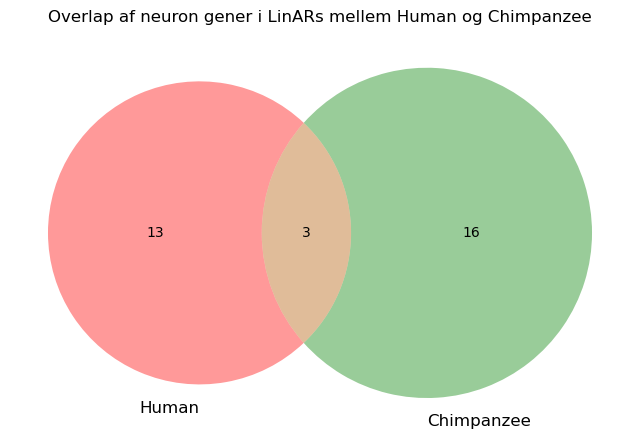

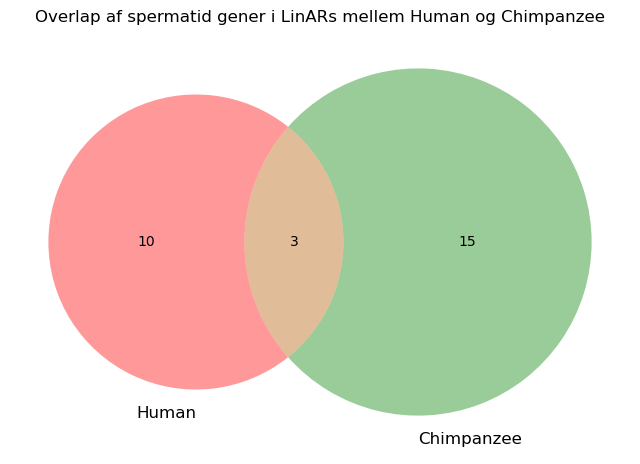

In [118]:
# Overlap between genes found in Human and Chimpanzee

# Neuron genes
plt.figure(figsize=(8,6))
venn2(
    subsets = (len(neuron_human_df) - len(neuron_human_df.merge(neuron_chimp_df, on="Gene_name")),
               len(neuron_chimp_df) - len(neuron_human_df.merge(neuron_chimp_df, on="Gene_name")),
               len(neuron_human_df.merge(neuron_chimp_df, on="Gene_name"))),
    set_labels = ('Human', 'Chimpanzee')
)
plt.title("Overlap af neuron gener i LinARs mellem Human og Chimpanzee")
plt.show()


# Spermatid genes
plt.figure(figsize=(8,6))
venn2(
    subsets = (len(spermatid_human_df) - len(spermatid_human_df.merge(spermatid_chimp_df, on="Gene_name")),
               len(spermatid_chimp_df) - len(spermatid_human_df.merge(spermatid_chimp_df, on="Gene_name")),
               len(spermatid_human_df.merge(spermatid_chimp_df, on="Gene_name"))),
    set_labels = ('Human', 'Chimpanzee')
)
plt.title("Overlap af spermatid gener i LinARs mellem Human og Chimpanzee")
plt.show()

### Find closest HAR for each gene in the neuron and spermatid list

### Are neuron and spermatid genes closest to the same HAR